In [1]:
# This is a script to generate nice readable tables for the identified clusters 
# Import libraries
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

from astropy.io import ascii
from astropy.table import Table


import warnings
warnings.filterwarnings("once")

In [2]:
import matplotlib
matplotlib.matplotlib_fname()

'/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [3]:
# Import data
cm_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
orb_param_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# Set all -9999 values in APOGEE and RAVE6 cnn [Fe/H] and alpha to np.nan for easier calculation later
ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_ap'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_r6c'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'m_h_ap17'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_ap'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_r6c'] = np.nan
cm_vel_all.loc[ind_ap17_999,'m_h_ap17'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'m_h_err_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'m_h_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'m_h_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'m_h_err_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'m_h_err_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'m_h_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'m_h_err_l6s'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'alpha_m_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_r6c'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'alpha_m_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_r6c'] = np.nan

ind_ap_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap'] < -100)[0]
ind_ap17_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_ap17'] < -100)[0]
ind_r6c_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_r6c'] < -100)[0]
ind_l6s_999 = np.where(cm_vel_all.loc[:,'alpha_m_err_l6s'] < -100)[0]
cm_vel_all.loc[ind_ap_999,'alpha_m_err_ap'] = np.nan
cm_vel_all.loc[ind_ap17_999,'alpha_m_err_ap17'] = np.nan
cm_vel_all.loc[ind_r6c_999,'alpha_m_err_r6c'] = np.nan
cm_vel_all.loc[ind_l6s_999,'alpha_m_err_l6s'] = np.nan

In [5]:
# Count the number of metallicity matches from each survey
datasets = ['ap17','r6c','l6s']
for dataset in datasets:
    N = len(np.where(np.isnan(cm_vel_all.loc[:,f'm_h_{dataset}']) == False)[0])
    print(f'Dataset {dataset} has {N} matches for metallicity.')
    
    N = len(np.where(np.isnan(cm_vel_all.loc[:,f'alpha_m_{dataset}']) == False)[0])
    print(f'Dataset {dataset} has {N} matches for alpha.')

Dataset ap17 has 211798 matches for metallicity.
Dataset ap17 has 211788 matches for alpha.
Dataset r6c has 293596 matches for metallicity.
Dataset r6c has 293649 matches for alpha.
Dataset l6s has 632223 matches for metallicity.
Dataset l6s has 0 matches for alpha.


In [6]:
# calculate the columns for the scaled action diamond
orb_param_all['Jtot'] = np.sqrt(orb_param_all['Jphi']**2+orb_param_all['JR']**2+orb_param_all['Jz']**2)
orb_param_all['diamond_x']=orb_param_all['Jphi']/orb_param_all['Jtot']
orb_param_all['diamond_y']=(orb_param_all['Jz']-orb_param_all['JR'])/orb_param_all['Jtot']

# Calculate the error for Jtot and diamond_x/y
orb_param_all['e_Jtot'] = np.sqrt(orb_param_all['Jphi']**2*orb_param_all['e_Jphi']**2+orb_param_all['JR']**2*orb_param_all['e_JR']**2+orb_param_all['Jz']**2*orb_param_all['e_Jz']**2)/orb_param_all['Jtot']
orb_param_all['e_diamond_x']=np.sqrt(orb_param_all['Jtot']**2*orb_param_all['e_Jphi']**2+orb_param_all['e_Jtot']**2*orb_param_all['Jphi']**2)/orb_param_all['Jtot']**2
orb_param_all['e_diamond_y']=np.sqrt(orb_param_all['Jtot']**2*(orb_param_all['e_JR']**2+orb_param_all['e_Jz']**2)+orb_param_all['e_Jtot']**2*(orb_param_all['Jz']-orb_param_all['JR'])**2)/orb_param_all['Jtot']**2

# Calculate L_perp for clustering
orb_param_all['Lperp'] = np.sqrt(orb_param_all['Lx']**2+orb_param_all['Ly']**2)
orb_param_all['e_Lperp'] = np.sqrt(orb_param_all['Lx']**2*orb_param_all['e_Lx']**2+orb_param_all['Ly']**2*orb_param_all['e_Ly']**2)/orb_param_all['Lperp']

# This mean metallicity below is only used in the case when we actually want to cluster in or with a prior cut on metallicity
# To avoid systematic differences between spectroscopic surveys; don't mix metallicities from different surveys
# cm_vel_all['m_h_mean'] = np.nanmean(cm_vel_all[['m_h_ap17','m_h_l6s','m_h_r6c','m_h_gl3']].values, axis=1).T
# cm_vel_all['m_h_mean'], cm_vel_all['e_m_h_mean'] = cm_vel_all['m_h_ap17'], cm_vel_all['m_h_err_ap17'] 
# cm_vel_all['m_h_mean'], cm_vel_all['e_m_h_mean'] = cm_vel_all['m_h_l6s'], cm_vel_all['m_h_err_l6s'] 

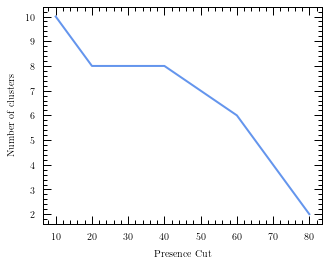

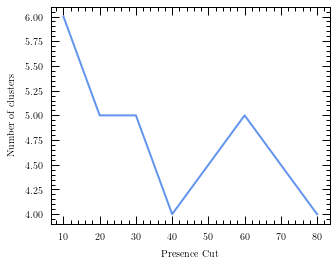

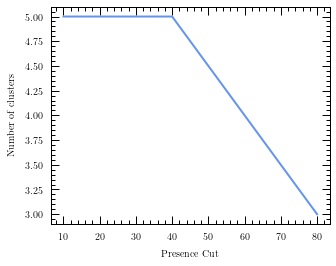

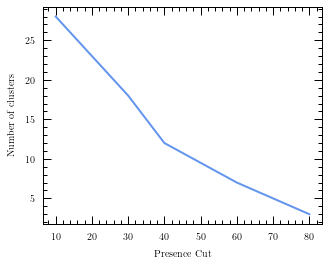

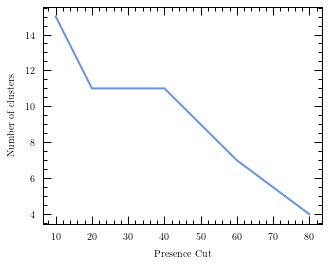

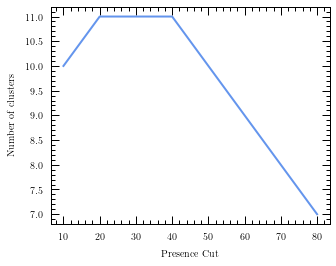

In [11]:
# Make number of clusters as a function of presence cut
for space, space_e in zip(['E_act', 'vel_cyl'], ['act_etot', 'vel_cyl']):
    for zcut in ['2500','3000','3500']:
        data_dir = './'+space+'_'+zcut+'_data_20_20_err_nocut/'
        plot_dir = './'+space+'_'+zcut+'_plot_20_20_err_nocut/'
        N_clust_tmp = []
        for pcut in ['10','20','30','40','60','80']:
            extratext = '_0412_Nstackcut_' + pcut + '_' + space_e + '_hdbscan_min_samples_20_min_clustsize_20_leaf_baseline'
            cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
            N_clust_tmp.append(len(cluster_id)-1)
        f = plt.figure(figsize=[5,4])
        plt.plot([10,20,30,40,60,80],N_clust_tmp)
        plt.xlabel(r'Presence Cut')
        plt.ylabel(r'Number of clusters')
        plt.show()
        f.savefig(plot_dir+space + '_' + zcut + '_N_clust_vs_presence_cut.pdf')

In [19]:
# Import the source_id of the identified clusters
# space = 'E_act'
# space_e = 'act_etot'
space = 'vel_cyl'
space_e = 'vel_cyl'
cut = '2500'
pcut = '20'

feh_from = 'l6s'
# feh_from = 'ap17'

# Use LAMOST or APOGEE for Fe/H
cm_vel_all['m_h_mean'], cm_vel_all['e_m_h_mean'] = cm_vel_all[f'm_h_{feh_from}'], cm_vel_all[f'm_h_err_{feh_from}'] 

data_dir = './' + space + '_' + cut + '_data_20_20_err_nocut/'
extratext = '_0412_Nstackcut_' + pcut + '_' + space_e + '_hdbscan_min_samples_20_min_clustsize_20_leaf_baseline'

cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
# cluster_ind = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
cluster_col = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
cluster_nstar = np.load(data_dir + 'member_nstar' + extratext + '.npy',allow_pickle=True)
cluster_means = np.load(data_dir + 'member_means' + extratext + '.npy',allow_pickle=True)
cluster_dispersions = np.load(data_dir + 'member_disps' + extratext + '.npy',allow_pickle=True)

In [20]:
cm_vel_all.columns

Index(['index', 'source_id', 'ra', 'dec', 'm_h_ap', 'm_h_err_ap', 'm_h_flg_ap',
       'alpha_m_ap', 'alpha_m_err_ap', 'alpha_m_flg_ap', 'm_h_l6s',
       'm_h_err_l6s', 'm_h_flg_l6s', 'alpha_m_l6s', 'alpha_m_err_l6s',
       'alpha_m_flg_l6s', 'm_h_gl3', 'm_h_err_gl3', 'm_h_flg_gl3',
       'alpha_m_gl3', 'alpha_m_err_gl3', 'alpha_m_flg_gl3', 'm_h_r6',
       'alpha_m_r6', 'm_h_err_r6', 'alpha_m_err_r6', 'XGC', 'YGC', 'ZGC',
       'm_h_r6c', 'alpha_m_r6c', 'm_h_err_r6c', 'alpha_m_err_r6c',
       'm_h_flg_r6c', 'alpha_m_flg_r6c', 'qual_flag', 'bin_flag', 'parallax',
       'parallax_error', 'parallax_zpcorr', 'l', 'b', 'XGCerr', 'YGCerr',
       'ZGCerr', 'U_g2', 'Uerr_g2', 'V_g2', 'Verr_g2', 'W_g2', 'Werr_g2',
       'UVcov_g2', 'UWcov_g2', 'VWcov_g2', 'v_forder_g2', 'vr_g2', 'vphi_g2',
       'vz_g2', 'vrerr_g2', 'vphierr_g2', 'vzerr_g2', 'vrphicov_g2',
       'vrzcov_g2', 'vphizcov_g2', 'm_h_ap17', 'm_h_err_ap17', 'alpha_m_ap17',
       'alpha_m_err_ap17', 'aspcap_flg_ap17', 'm_h_

In [21]:
# count how many clusters are identified. Note the last one is always noise
print("Number of identified clusters:",len(cluster_id)-1)

Number of identified clusters: 23


In [22]:
str(cluster_col[1][0:3])

'[1.         0.25477967 0.        ]'

In [23]:
# Create a dataframe to hold all the output
if space == 'vel_cyl':

    df_output = pd.DataFrame({'Cluster ID': np.arange(len(cluster_id)-1),\
                              'Color': [np.nan]*(len(cluster_id)-1),\
                              '$v_{R}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{v_{R}}$': np.zeros(len(cluster_id)-1),\
                              '$v_{\phi}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{v_{\phi}}$': np.zeros(len(cluster_id)-1),\
                              '$v_{z}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{v_{z}}$': np.zeros(len(cluster_id)-1)
                             })
elif space == 'E_act':
    df_output = pd.DataFrame({'Cluster ID': np.arange(len(cluster_id)-1),\
                              'Color': [np.nan]*(len(cluster_id)-1),\
                              '$J_{R}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{J_{R}}$': np.zeros(len(cluster_id)-1),\
                              '$J_{\phi}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{J_{\phi}}$': np.zeros(len(cluster_id)-1),\
                              '$J_{z}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{J_{z}}$': np.zeros(len(cluster_id)-1),\
                              '$E_{tot}$': np.zeros(len(cluster_id)-1),\
                              '$\sigma_{E_{tot}}$': np.zeros(len(cluster_id)-1)
                             })


In [24]:
# Search the corresponding index list
cluster_ind_match = []
for i in range(len(cluster_id)-1):
    source_id_tmp = cluster_id[i]
    ind_tmp = np.array([np.where(cm_vel_all['source_id'] == s_id)[0][0] for s_id in source_id_tmp])
    cluster_ind_match.append(ind_tmp)
    
    converted_col = [str(element) for element in cluster_col[i][0:3]]
    df_output.loc[i,'Color'] = ",".join(converted_col)
    
    if space == 'vel_cyl':
    
        df_output.loc[i,'$v_{R}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vr_g2'])
        df_output.loc[i,'$\sigma_{v_{R}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vr_g2'])

        df_output.loc[i,'$v_{\phi}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vphi_g2'])
        df_output.loc[i,'$\sigma_{v_{\phi}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vphi_g2'])

        df_output.loc[i,'$v_{z}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vz_g2'])
        df_output.loc[i,'$\sigma_{v_{z}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vz_g2'])
    
    elif space == 'E_act':
    
        df_output.loc[i,'$J_{R}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'JR'])
        df_output.loc[i,'$\sigma_{J_{R}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'JR'])

        df_output.loc[i,'$J_{\phi}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Jphi'])
        df_output.loc[i,'$\sigma_{J_{\phi}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Jphi'])

        df_output.loc[i,'$J_{z}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Jz'])
        df_output.loc[i,'$\sigma_{J_{z}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Jz'])

        df_output.loc[i,'$E_{tot}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Etot'])
        df_output.loc[i,'$\sigma_{E_{tot}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Etot'])
    
    # Additional columns as needed
    df_output.loc[i,'$ecc$'] = np.nanmean(orb_param_all.loc[ind_tmp,'ecc'])
    df_output.loc[i,'$[Fe/H]$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'m_h_mean'])
    df_output.loc[i,'$N_{[Fe/H]}$'] = int(len(np.where(np.isnan(cm_vel_all.loc[ind_tmp,'m_h_mean']) == False)[0]))
    
    
    df_output.loc[i,'$N_{star}$'] = int(len(source_id_tmp))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


In [25]:
# Round the decimals
if space == 'vel_cyl':
    for (col, dp) in zip(['$v_{R}$','$\sigma_{v_{R}}$','$v_{\phi}$','$\sigma_{v_{\phi}}$','$v_{z}$','$\sigma_{v_{z}}$'],[2,2,2,2,2,2]):
        df_output[col] = df_output[col].round(dp)
elif space == 'E_act':
    for (col, dp) in zip(['$J_{R}$','$\sigma_{J_{R}}$','$J_{\phi}$','$\sigma_{J_{\phi}}$','$J_{z}$','$\sigma_{J_{z}}$','$E_{tot}$','$\sigma_{E_{tot}}$'],[2,2,2,2,2,2,2,2]):
        df_output[col] = df_output[col].round(dp)

for (col, dp) in zip(['$ecc$', '$[Fe/H]$'], [2,2]):
    df_output[col] = df_output[col].round(dp)
    
# for (col, dp) in zip(['$N_{[Fe/H]}$', '$N_{star}$'], [0,0]):
#     df_output[col] = df_output[col].round(dp)

df_output = df_output.astype({'$N_{[Fe/H]}$': int, '$N_{star}$': int})
    
# Process the color column
df_output['Color'] = r'\textcolor[rgb]{' + df_output['Color'] + r'}{$\blacksquare$}'

In [26]:
df_output

,Cluster ID,Color,$v_{R}$,$\sigma_{v_{R}}$,$v_{\phi}$,$\sigma_{v_{\phi}}$,$v_{z}$,$\sigma_{v_{z}}$,$ecc$,$[Fe/H]$,$N_{[Fe/H]}$,$N_{star}$
0,0,"\textcolor[rgb]{1.0,0.0,0.0}{$\blacksquare$}",-100.93,14.21,291.85,15.01,145.05,16.55,0.53,NaN,0,63
1,1,"\textcolor[rgb]{1.0,0.2547796665443724,0.0}{$\...",97.72,11.55,-2.75,19.65,-112.26,10.35,0.88,-1.16,9,39
2,2,"\textcolor[rgb]{1.0,0.5095593330887448,0.0}{$\...",110.00,4.39,-171.90,5.72,-95.88,4.74,0.36,-0.61,7,26
3,3,"\textcolor[rgb]{1.0,0.764338999633117,0.0}{$\b...",-111.46,5.48,-159.53,10.44,-106.72,5.86,0.41,-0.70,11,42
4,4,"\textcolor[rgb]{0.9727937779408368,0.991912444...",-109.77,16.78,-21.44,7.12,-110.45,9.18,0.86,-1.07,16,59
5,5,"\textcolor[rgb]{0.726101667278138,1.0,0.0}{$\b...",-281.08,26.82,-5.67,13.93,72.80,25.23,0.96,-1.47,8,64
6,6,"\textcolor[rgb]{0.4713220007337658,1.0,0.0}{$\...",-204.84,12.42,-19.40,11.72,-117.92,13.30,0.91,-0.99,2,24
7,7,"\textcolor[rgb]{0.21654233418939306,1.0,0.0}{$...",24.75,8.75,-19.96,9.28,93.65,7.35,0.85,-1.11,4,26
8,8,"\textcolor[rgb]{0.0003669599257835228,1.0,0.06...",-41.78,19.17,-11.60,11.10,97.05,8.69,0.89,-0.99,15,56
9,9,"\textcolor[rgb]{0.0,1.0,0.3161771885991356}{$\...",36.39,14.65,-151.04,11.71,-106.22,6.46,0.28,-0.65,26,167


In [15]:
# Examine to make sure the velocities and indices are properly exported
i = 1
# print(cluster_ind[i],cluster_ind_match[i])
print(cluster_means[i],cluster_dispersions[i])
print(cluster_nstar)

[ 1.71360990e+03 -2.79899072e+01  6.96682472e+01 -1.09012713e+05] [  90.77040872  104.25098538   17.76023719 2403.22340899]
[ 65.  55.  59. 155.  57. 287. 131. 106.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 168.]


In [27]:
t = Table.from_pandas(df_output)

In [28]:
# Add units to the table
if space == 'vel_cyl':
    for col in ['$v_{R}$','$\sigma_{v_{R}}$','$v_{\phi}$','$\sigma_{v_{\phi}}$','$v_{z}$','$\sigma_{v_{z}}$']:
        t[col] = t[col]*u.km/u.s
elif space == 'E_act':
    for col in ['$J_{R}$','$\sigma_{J_{R}}$','$J_{\phi}$','$\sigma_{J_{\phi}}$','$J_{z}$','$\sigma_{J_{z}}$']:
        t[col] = t[col]*u.kpc*u.km/u.s
    for col in ['$E_{tot}$','$\sigma_{E_{tot}}$']:
        t[col] = t[col]*u.km**2/u.s**2

t['$[Fe/H]$'] = t['$[Fe/H]$']*u.dex

<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \p


In [29]:
ascii.write(t, f'clustering_result_tables/tab_{extratext}_feh_{feh_from}.tex', overwrite=True,format='aastex')

In [34]:
df_output.to_csv(data_dir+'mean_result_table.csv')

In [35]:
# loop through the sampling realizations and outputs all tables to the data directory
E_act_flg = True
vel_cyl_flg = False

for j in range(100):
    extratext = '_0217_g2only_err_abs_cut_zmax_cut_2500_act_etot_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_' + str(j)
    cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
    cluster_ind = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
    cluster_col = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
    cluster_nstar = np.load(data_dir + 'member_nstar' + extratext + '.npy',allow_pickle=True)
    cluster_means = np.load(data_dir + 'member_means' + extratext + '.npy',allow_pickle=True)
    cluster_dispersions = np.load(data_dir + 'member_disps' + extratext + '.npy',allow_pickle=True)
    
    # count how many clusters are identified. Note the last one is always noise
    print("Number of identified clusters for realization",j,":",len(cluster_id)-1)
    
    # Create a dataframe to hold all the output
    if vel_cyl_flg:
        df_output = pd.DataFrame({'Cluster ID': np.arange(len(cluster_id)-1),\
                                  'Color': [np.nan]*(len(cluster_id)-1),\
                                  '$v_{R}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{v_{R}}$': np.zeros(len(cluster_id)-1),\
                                  '$v_{\phi}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{v_{\phi}}$': np.zeros(len(cluster_id)-1),\
                                  '$v_{z}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{v_{z}}$': np.zeros(len(cluster_id)-1),\
                                  '$N_{star}$': np.zeros(len(cluster_id)-1,dtype=int)})
    
    if E_act_flg:
        df_output = pd.DataFrame({'Cluster ID': np.arange(len(cluster_id)-1),\
                                  'Color': [np.nan]*(len(cluster_id)-1),\
                                  '$J_{R}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{J_{R}}$': np.zeros(len(cluster_id)-1),\
                                  '$J_{\phi}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{J_{\phi}}$': np.zeros(len(cluster_id)-1),\
                                  '$J_{z}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{J_{z}}$': np.zeros(len(cluster_id)-1),\
                                  '$E_{tot}$': np.zeros(len(cluster_id)-1),\
                                  '$\sigma_{E_{tot}}$': np.zeros(len(cluster_id)-1),\
                                  '$N_{star}$': np.zeros(len(cluster_id)-1,dtype=int)})
    
    cluster_ind_match = []
    
    # Search the corresponding index list
    if vel_cyl_flg:
        for i in range(len(cluster_id)-1):
            source_id_tmp = cluster_id[i]
            ind_tmp = np.array([np.where(cm_vel_all['source_id'] == s_id)[0][0] for s_id in source_id_tmp])
            cluster_ind_match.append(ind_tmp)

            converted_col = [str(element) for element in cluster_col[i][0:3]]
            df_output.loc[i,'Color'] = ",".join(converted_col)

            df_output.loc[i,'$v_{R}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vr_g2'])
            df_output.loc[i,'$\sigma_{v_{R}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vr_g2'])

            df_output.loc[i,'$v_{\phi}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vphi_g2'])
            df_output.loc[i,'$\sigma_{v_{\phi}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vphi_g2'])

            df_output.loc[i,'$v_{z}$'] = np.nanmean(cm_vel_all.loc[ind_tmp,'vz_g2'])
            df_output.loc[i,'$\sigma_{v_{z}}$'] = np.nanstd(cm_vel_all.loc[ind_tmp,'vz_g2'])

            df_output.loc[i,'$N_{star}$'] = int(len(source_id_tmp))
        
        # Round the decimals
        for (col, dp) in zip(['$v_{R}$','$\sigma_{v_{R}}$','$v_{\phi}$','$\sigma_{v_{\phi}}$','$v_{z}$','$\sigma_{v_{z}}$'],[2,2,2,2,2,2]):
            df_output[col] = df_output[col].round(dp)

    if E_act_flg:
        for i in range(len(cluster_id)-1):
            source_id_tmp = cluster_id[i]
            ind_tmp = np.array([np.where(cm_vel_all['source_id'] == s_id)[0][0] for s_id in source_id_tmp])
            cluster_ind_match.append(ind_tmp)

            converted_col = [str(element) for element in cluster_col[i][0:3]]
            df_output.loc[i,'Color'] = ",".join(converted_col)

            df_output.loc[i,'$J_{R}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'JR'])
            df_output.loc[i,'$\sigma_{J_{R}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'JR'])

            df_output.loc[i,'$J_{\phi}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Jphi'])
            df_output.loc[i,'$\sigma_{J_{\phi}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Jphi'])

            df_output.loc[i,'$J_{z}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Jz'])
            df_output.loc[i,'$\sigma_{J_{z}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Jz'])

            df_output.loc[i,'$E_{tot}$'] = np.nanmean(orb_param_all.loc[ind_tmp,'Etot'])
            df_output.loc[i,'$\sigma_{E_{tot}}$'] = np.nanstd(orb_param_all.loc[ind_tmp,'Etot'])


            df_output.loc[i,'$N_{star}$'] = int(len(source_id_tmp))
            
            
        # Round the decimals    
        for (col, dp) in zip(['$J_{R}$','$\sigma_{J_{R}}$','$J_{\phi}$','$\sigma_{J_{\phi}}$','$J_{z}$','$\sigma_{J_{z}}$','$E_{tot}$','$\sigma_{E_{tot}}$'],[2,2,2,2,2,2,2,2]):
            df_output[col] = df_output[col].round(dp)
        
    # Process the color column
    df_output['Color'] = '\textcolor[rgb]{' + df_output['Color'] + '}{$\blacksquare$}'
    
    df_output.to_csv(data_dir+'mean_result_table_samp_'+str(j)+'.csv')

<>:22: DeprecationWarning: invalid escape sequence \s
<>:23: DeprecationWarning: invalid escape sequence \p


Number of identified clusters for realization 0 : 13
Number of identified clusters for realization 1 : 10
Number of identified clusters for realization 2 : 11
Number of identified clusters for realization 3 : 16
Number of identified clusters for realization 4 : 8
Number of identified clusters for realization 5 : 10
Number of identified clusters for realization 6 : 12
Number of identified clusters for realization 7 : 12
Number of identified clusters for realization 8 : 10
Number of identified clusters for realization 9 : 10
Number of identified clusters for realization 10 : 11
Number of identified clusters for realization 11 : 9
Number of identified clusters for realization 12 : 12
Number of identified clusters for realization 13 : 9
Number of identified clusters for realization 14 : 10
Number of identified clusters for realization 15 : 15
Number of identified clusters for realization 16 : 9
Number of identified clusters for realization 17 : 9
Number of identified clusters for realizati

In [26]:
cluster_col

array([[0.00392157, 0.45098039, 0.69803922, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.3372549 , 0.70588235, 0.91372549, 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.9254902 , 0.88235294, 0.2       , 1.        ],
       [0.58039216, 0.58039216, 0.58039216, 1.        ],
       [0.58039216, 0.58039216, 0.58039216, 1.        ],
       [0.58039216, 0.58039216, 0.58039216, 1.        ],
       [0.58039216, 0.58039216,

In [69]:
# Make 1d histogram
def plot_1d_hist(df_vel,df_orb,ind_list,c_list,title,legends,list_mask=False,filename=None,bg=False,ds=True,ind_add_cut=[],ind_bg=[]):
    if len(ind_add_cut) == 0 and list_mask == True:
        ind_add_cut = ind_cut
    
    f = plt.figure(figsize=[10,10])
    
#     plt.suptitle(title)
    
    # Set the plotting parameters
    plt.subplot(2,2,1)
    plt.xlim([-600,600])
    plt.xlabel(r'$v_{R}$ [km/s]')
    plt.ylabel(r'$f(v_{R})$')
    
    # Make a fake dot for the legend
    for i in range(len(ind_list)):
        if ((len(ind_list[i]) < 0.1*len(df_vel)) or (len(ind_list) == 1)) and bg == False:
            mkr='*'
            ec='k'
        else:
            mkr='.'
            ec=c_list[i][0]
        try:
            # Check if needs downsampling; if so, flag it in legend
            if len(ind_list[i]) > 5000 and ds == True:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i]+'_sp',marker=mkr,edgecolors=ec)
            else:
                plt.scatter([],[],s=100,alpha=0.8,c=c_list[i][0],label=legends[i],marker=mkr,edgecolors=ec)
        except IndexError:
            print("Cluster number:",legends[i],'has zero stars.')
#     plt.legend(fontsize='small')
    
    plt.subplot(2,2,2)
    plt.xlim([-600,600])
    plt.xlabel(r'$v_{\phi}$ [km/s]')
    plt.ylabel(r'$f(v_{\phi})$')
    
    plt.subplot(2,2,3)
    plt.xlim([-600,600])
    plt.xlabel(r'$v_{z}$ [km/s]')
    plt.ylabel(r'$f(v_{z})$')
    
    plt.subplot(2,2,4)
    plt.xlim([-600,600])
    plt.xlabel(r'$|v|$ [km/s]')
    plt.ylabel(r'$f(|v|)$')

    # Add the backgrounds as needed
    if len(ind_bg) != 0:
        plt.subplot(2,2,1)
        sns.distplot(df_vel.loc[ind_bg,'vr_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color='k')


        # Plot vphi histogram
        plt.subplot(2,2,2)
        sns.distplot(df_vel.loc[ind_bg,'vphi_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color='k')


        # Plot vz histogram
        plt.subplot(2,2,3)
        sns.distplot(df_vel.loc[ind_bg,'vz_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color='k')


        # Plot vphi vs. vr; flip vphi
        plt.subplot(2,2,4)
        sns.distplot(np.sqrt(df_vel.loc[ind_bg,'vr_g2']**2+df_vel.loc[ind_bg,'vphi_g2']**2+df_vel.loc[ind_bg,'vz_g2']**2),hist=False,kde=True,bins=np.arange(0,600,10),color='k')
            
        
    
    for i in range(len(ind_list)):
        if list_mask == True:
            ind = ind_add_cut[ind_list[i]]
        else:
            ind = ind_list[i]
        color = c_list[i]
        
            
        if (len(ind) < 0.1*len(df_vel) or (len(ind_list) == 1)) and bg == False:
            mkr='.'
            ms=50
            al=1 
#             ec=['k']*len(ind)
            ec='none'
        else:
            mkr='.'
            ms=10
            al=0.1
            ec=color
        
        # Determine if there are more than 10000 data points, if so, down-sample it
        if len(ind) > 5000 and ds == True:
            ii = np.random.choice(len(ind),int(len(ind)/20),replace=False)
            ind = ind[ii]
            
            # Check to see if color list also needs to be downsampled
            if len(color) > len(ind): 
                color = color[ii]
        
        
        # Plot vr histogram
        plt.subplot(2,2,1)
        sns.distplot(df_vel.loc[ind,'vr_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color=color)
        plt.xlabel(r'$v_{R}$ [km/s]')
        
        
        # Plot vphi histogram
        plt.subplot(2,2,2)
        sns.distplot(df_vel.loc[ind,'vphi_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color=color)
        plt.xlabel(r'$v_{\phi}$ [km/s]')
        
        # Plot vz histogram
        plt.subplot(2,2,3)
        sns.distplot(df_vel.loc[ind,'vz_g2'],hist=False,kde=True,bins=np.arange(-600,600,10),color=color)
        plt.xlabel(r'$v_{z}$ [km/s]')
        
        # Plot v_tot histogram
        plt.subplot(2,2,4)
        sns.distplot(np.sqrt(df_vel.loc[ind,'vr_g2']**2+df_vel.loc[ind,'vphi_g2']**2+df_vel.loc[ind,'vz_g2']**2),hist=False,kde=True,bins=np.arange(0,600,10),color=color)
        plt.xlabel(r'$|v|$ [km/s]')
        
        
            
        
    f.tight_layout()
    plt.show()
    if filename != None:
        f.savefig(filename,layout='tight')

In [63]:
# sns.distplot(cm_vel_all.loc[ind_cut,'vphi_g2'],hist=False,kde=True,bins=vphi_bin, label=str(cutoff_l_arr[i])+'< zmax <'+str(cutoff_h_arr[i]))


Cluster number: 0 has zero stars.
Cluster number: 1 has zero stars.
Cluster number: 2 has zero stars.
Cluster number: 3 has zero stars.
Cluster number: 4 has zero stars.
Cluster number: 5 has zero stars.
Cluster number: 6 has zero stars.
Cluster number: 7 has zero stars.
Cluster number: 8 has zero stars.
Cluster number: 9 has zero stars.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

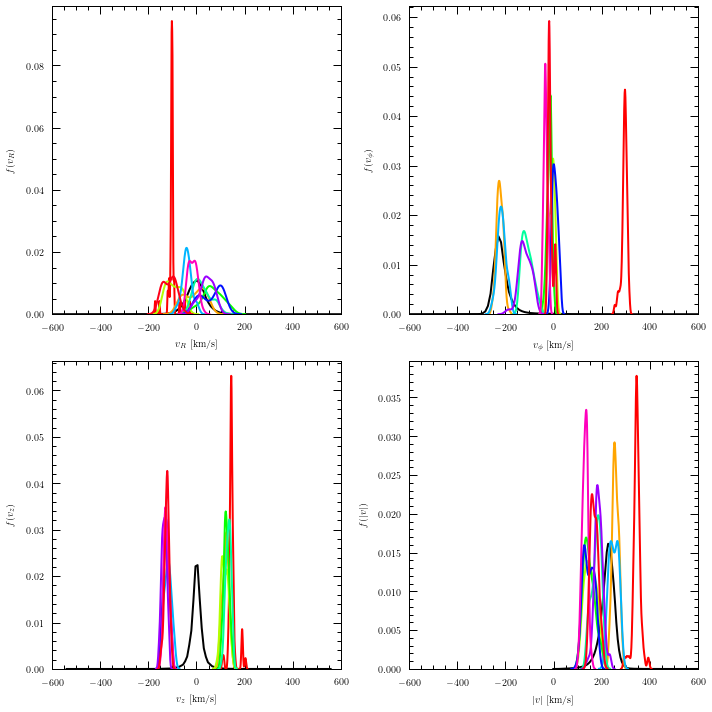

In [70]:
plot_1d_hist(cm_vel_all,orb_param_all,cluster_impot_ind,title='',c_list=[plt.cm.hsv(each) for each in np.linspace(0, 1, len(cluster_impot_ind))],\
             legends=np.arange(len(cluster_impot_ind)),list_mask=False,filename='action_plots/'+extratext+'_1d_hist.pdf',bg=False,ds=False,ind_add_cut=[],ind_bg=range(len(cm_vel_all)))